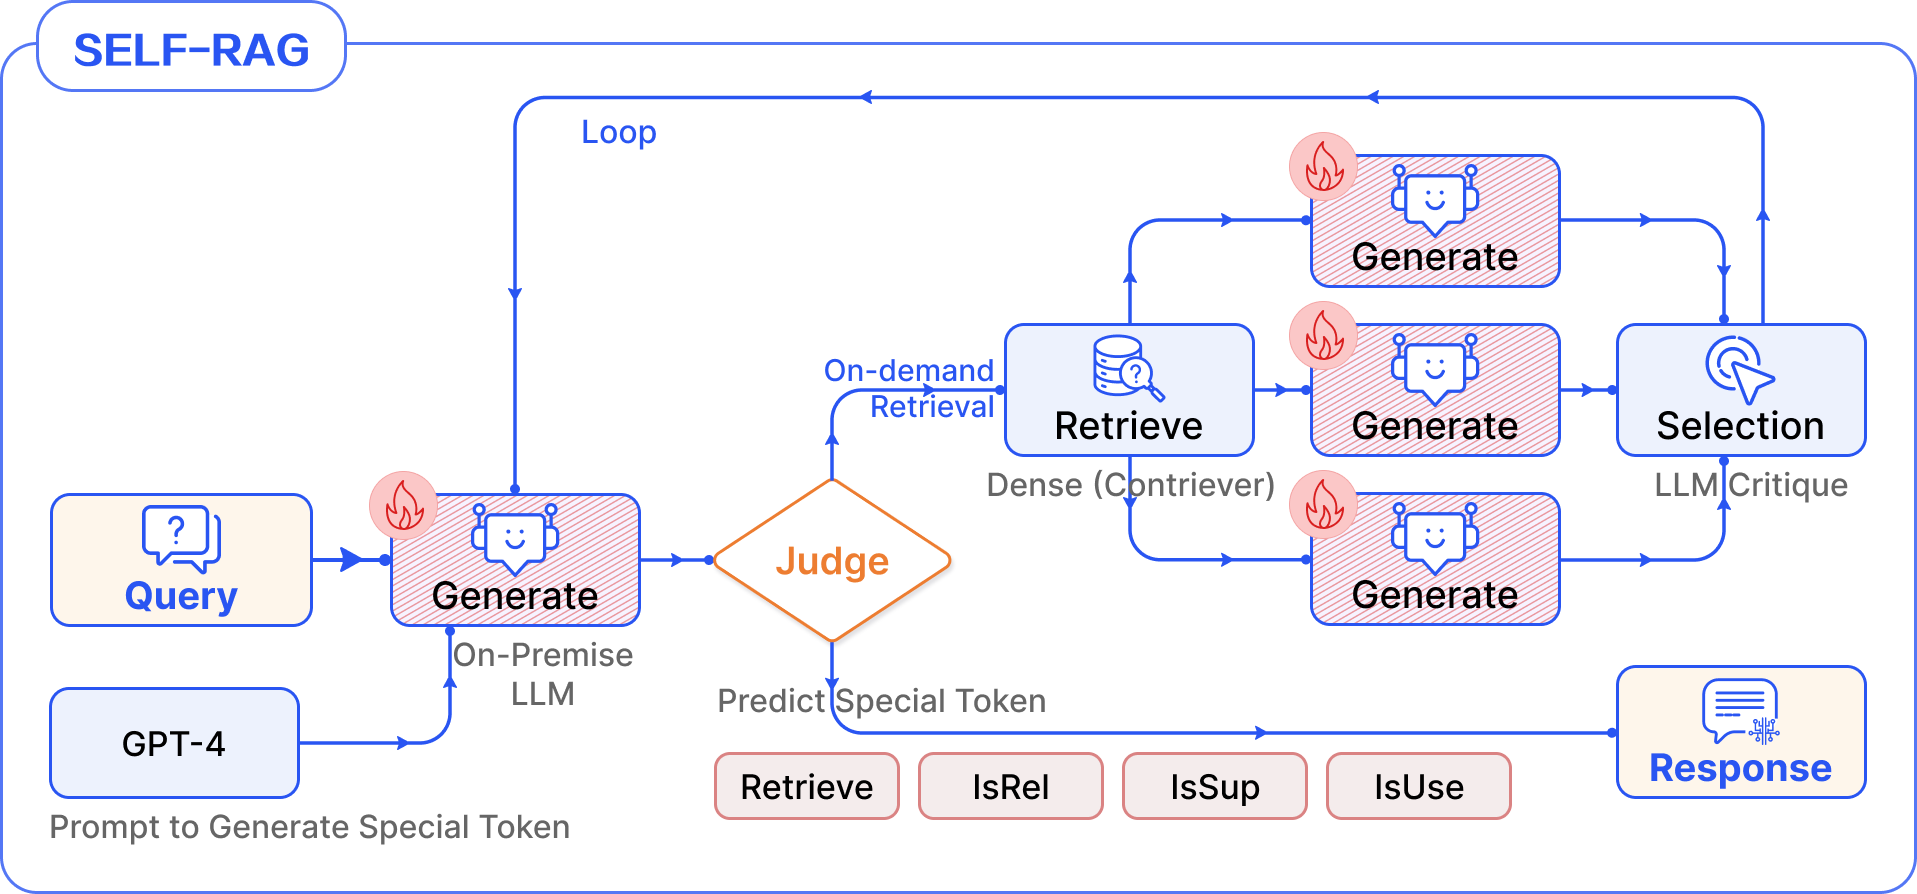

In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

GOOGLE_API_KEY=os.getenv("GEMINI_API_KEY")
LANGCHAIN_API_KEY=os.getenv("LANGCHAIN_API_KEY")

os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY
os.environ["LANGCHAIN_API_KEY"] = LANGCHAIN_API_KEY


In [2]:

# from langchain_google_genai import GoogleGenerativeAIEmbeddings
# embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001")

# from langchain_google_genai import ChatGoogleGenerativeAI
# llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash")

In [3]:
from langchain_huggingface import HuggingFaceEmbeddings
embeddings=HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

from langchain_groq import ChatGroq
llm=ChatGroq(model_name="Gemma2-9b-It")

In [4]:
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [5]:
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
]

In [6]:
docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

# for sublist in docs:
#     for item in sublist:
#         print(item) # 2d to 1d

In [7]:
docs

[[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final res

In [8]:
docs_list

[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final resu

In [9]:
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=100, chunk_overlap=50
)

In [10]:
text_splitter

In [11]:
doc_splits = text_splitter.split_documents(docs_list)

In [12]:
doc_splits

[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final resu

In [13]:
# Add to vectorDB
vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chroma",
    embedding=embeddings,
)

In [14]:
vectorstore

In [15]:
retriever = vectorstore.as_retriever()

In [16]:
retriever

VectorStoreRetriever(tags=['Chroma', 'HuggingFaceEmbeddings'], vectorstore=<langchain_community.vectorstores.chroma.Chroma object at 0x0000020C1D7E1ED0>, search_kwargs={})

In [17]:
from langchain.tools.retriever import create_retriever_tool

In [18]:
retriever_tool = create_retriever_tool(
    retriever,
    "retrieve_blog_posts",
    "Search and return information about Lilian Weng blog posts on LLM agents, prompt engineering, and adversarial attacks on LLMs.",
)

In [19]:
tools = [retriever_tool]

In [20]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field

d:\a27_YEARS_OLD\langgraph\venv\Lib\site-packages\IPython\core\interactiveshell.py:3577: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


In [21]:
# Data model
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )

In [22]:
# LLM with function call
structured_llm_grader = llm.with_structured_output(GradeDocuments)

In [23]:
# Prompt
system = """You are a grader checking if a document is relevant to a user’s question.The check has to be done very strictly..  
If the document has words or meanings related to the question, mark it as relevant.  
Give a simple 'yes' or 'no' answer to show if the document is relevant or not."""

In [24]:
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

In [25]:
grade_prompt

ChatPromptTemplate(input_variables=['document', 'question'], input_types={}, partial_variables={}, messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=[], input_types={}, partial_variables={}, template="You are a grader checking if a document is relevant to a user’s question.The check has to be done very strictly..  \nIf the document has words or meanings related to the question, mark it as relevant.  \nGive a simple 'yes' or 'no' answer to show if the document is relevant or not."), additional_kwargs={}), HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['document', 'question'], input_types={}, partial_variables={}, template='Retrieved document: \n\n {document} \n\n User question: {question}'), additional_kwargs={})])

In [26]:
my_retrieval_grader = grade_prompt | structured_llm_grader

In [27]:
question = "what is ai agent?"

In [28]:
docs = retriever.get_relevant_documents(question)

C:\Users\lenovo\AppData\Local\Temp\ipykernel_3844\10663643.py:1: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  docs = retriever.get_relevant_documents(question)


In [29]:
docs

[Document(metadata={'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final results.\n\n\nMemory\n\nShort-term memory: I would consider all the in-context learning (See Prompt Engineering) as utiliz

In [33]:
doc_txt = docs[0].page_content

In [34]:
doc_txt

'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview#'

In [35]:
print(my_retrieval_grader.invoke({"document":doc_txt,"question": question}))

binary_score='yes'


In [ ]:
# Chain-of-Thought (CoT)
# Chain-of-thought (CoT) prompting (Wei et al. 2022) generates a sequence of short sentences to describe reasoning logics step by step, known as reasoning chains or rationales, to eventually lead to the final answer. The benefit of CoT is more pronounced for complicated reasoning tasks, while using large models (e.g. with more than 50B parameters). Simple tasks only benefit slightly from CoT prompting.

# Types of CoT prompts
# Two main types of CoT prompting:

# Few-shot CoT. It is to prompt the model with a few demonstrations, each containing manually written (or model-generated) high-quality reasoning chains.
# Question: Tom and Elizabeth have a competition to climb a hill. Elizabeth takes 30 minutes to climb the hill. Tom takes four times as long as Elizabeth does to climb the hill. How many hours does it take Tom to climb up the hill?
# Answer: It takes Tom 30*4 = <<30*4=120>>120 minutes to climb the hill.
# It takes Tom 120/60 = <<120/60=2>>2 hours to climb the hill.
# So the answer is 2.
# ===
# Question: Jack is a soccer player. He needs to buy two pairs of socks and a pair of soccer shoes. Each pair of socks cost $9.50, and the shoes cost $92. Jack has $40. How much more money does Jack need?
# Answer: The total cost of two pairs of socks is $9.50 x 2 = $<<9.5*2=19>>19.
# The total cost of the socks and the shoes is $19 + $92 = $<<19+92=111>>111.
# Jack need $111 - $40 = $<<111-40=71>>71 more.
# So the answer is 71.
# ===
# Question: Marty has 100 centimeters of ribbon that he must cut into 4 equal parts. Each of the cut parts must be divided into 5 equal parts. How long will each final cut be?
# Answer:
# Zero-shot CoT. Use natural language statement like Let's think step by step to explicitly encourage the model to first generate reasoning chains and then to prompt with Therefore, the answer is to produce answers (Kojima et al. 2022 ). Or a similar statement Let's work this out it a step by step to be sure we have the right answer (Zhou et al. 2022).
# Question: Marty has 100 centimeters of ribbon that he must cut into 4 equal parts. Each of the cut parts must be divided into 5 equal parts. How long will each final cut be?
# Answer: Let's think step by step.
# Tips and Extensions
# Self-consistency sampling can improve reasoning accuracy by sampling a number of diverse answers and then taking the majority vote. (Wang et al. 2022a)

# Another approach for ensemble learning is to alter the example order or use model generated rationales to replace human-written ones to introduce randomness during multiple sample trials. Then aggregate model outputs with a majority vote to get final answer. (Wang et al. 2022b)

# If training examples are only associated with true answers (easy to verify!) but no rationales, we can follow the STaR (Self-Taught Reasoner; Zelikman et al. 2022) method : (1) Ask LLM to generate reasoning chains and only keep those leading to correct answers; (2) Then fine-tune the model with generated rationales and repeat the process until convergence. Note that higher temperature is more likely to generate incorrect rationales with correct answers. If training examples do not have ground truth answers, maybe consider using majority votes as the “correct” answers.

# Prompts with demonstrations of higher reasoning complexity can achieve better performance, where complexity is measured by the number of reasoning steps in the chains. When separating reasoning steps, newline \n symbol works better than step i, period . or semicolon ;. (Fu et al. 2023)

# Complexity-based consistency is to explicitly prefer complex chains among all the generations by taking majority vote among only top 
#  complex chains. (Fu et al. 2023)

# Later, Shum et al. (2023) found that in their experiments CoT prompts with only complex examples can improve the accuracy of complex questions, but perform poorly in simple questions; evidence shown on GSM8k.

# Changing Q: to Question: is found to be helpful. (Fu et al. 2023)

# Ye & Durrett (2022) found that the benefit of including explanations in the prompt is small to moderate for NLP tasks that involve reasoning over text (i.e. QA and NLI) and the effects vary by models. They observed that explanations are more likely to be nonfactual than be inconsistent (i.e. whether explanation entails prediction). Nonfactual explanations most likely lead to incorrect predictions.

# Self-Ask (Press et al. 2022) is a method to repeatedly prompt the model to ask following-up questions to construct the thought process iteratively. Follow-up questions can be answered by search engine results. Similarly, IRCoT (Interleaving Retrieval CoT; Trivedi et al. 2022) and ReAct (Reason + Act; Yao et al. 2023) combines iterative CoT prompting with queries to Wikipedia APIs to search for relevant entities and content and then add it back into the context.
# Tree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at each step. It first decomposes the problem into multiple thought steps and generates multiple thoughts per step, essentially creating a tree structure. The search process can be BFS or DFS while each state is evaluated by a classifier (via a prompt) or majority vote.

# Fig. 2. How Self-Ask works with external search queries.
# (Image source: Yao et al. 2022).
# Automatic Prompt Design
# Prompt is a sequence of prefix tokens that increase the probability of getting desired output given input. Therefore we can treat them as trainable parameters and optimize them directly on the embedding space via gradient descent, such as AutoPrompt (Shin et al., 2020, Prefix-Tuning (Li & Liang (2021)), P-tuning (Liu et al. 2021) and Prompt-Tuning (Lester et al. 2021). This section in my “Controllable Neural Text Generation” post has a good coverage of them. The trend from AutoPrompt to Prompt-Tuning is that the setup gets gradually simplified.

# APE (Automatic Prompt Engineer; Zhou et al. 2022) is a method to search over a pool of model-generated instruction candidates and then filters the candidate set according to a chosen score function to ultimately choose the best candidate with highest score.

# Prompt LLM to generate instruction candidates based on a small set of demonstrations in the form of input-output pairs. E.g. {{Given desired input-output pairs}}\n\nThe instruction is.

# Given a dataset of 
# , we would like to find an instruction 
#  such that 
# , where 
#  is a per-sample score function, such as execution accuracy 𝟙
#  or log probability: 
# .

# Use an iterative Monte Carlo search method to improve the best candidates by proposing semantically similar variants via prompts like Generate a variation of the following instruction while keeping the semantic meaning.\n\nInput: ...\n\nOutput:...

# To construct chain-of-thought prompts automatically, Shum et al. (2023) suggested augment-prune-select, a three-step process:

# Augment: Generate multiple pseudo-chains of thought given question using few-shot or zero-shot CoT prompts;
# Prune: Prune pseudo chains based on whether generated answers match ground truths.
# Select: Apply a variance-reduced policy gradient strategy to learn the probability distribution over selected examples, while considering the probability distribution over examples as policy and the validation set accuracy as reward.
# Zhang et al. (2023) instead adopted clustering techniques to sample questions and then generates chains. They observed that LLMs tend to make certain types of mistakes. One type of errors can be similar in the emebedding space and thus get grouped together. By only sampling one or a few from frequent-error clusters, we can prevent too many wrong demonstrations of one error type and collect a diverse set of examples.

# Question clustering: Embed questions and run 
# -means for clustering.
# Demonstration selection: Select a set of representative questions from each cluster; i.e. one demonstration from one cluster. Samples in each cluster are sorted by distance to the cluster centroid and those closer to the centroid are selected first.
# Rationale generation: Use zero-shot CoT to generate reasoning chains for selected questions and construct few-shot prompt to run inference.
# Augmented Language Models
# A survey on augmented language models by Mialon et al. (2023) has great coverage over multiple categories of language models augmented with reasoning skills and the ability of using external tools. Recommend it.

# Retrieval
# Often we need to complete tasks that require latest knowledge after the model pretraining time cutoff or internal/private knowledge base. In that case, the model would not know the context if we don’t explicitly provide it in the prompt. Many methods for Open Domain Question Answering depend on first doing retrieval over a knowledge base and then incorporating the retrieved content as part of the prompt. The accuracy of such a process depends on the quality of both retrieval and generation steps.

# Lazaridou et al. (2022) studied how to use Google Search for document retrieval to augment LLMs. Given a question 
# , clean text is extracted out of 20 URLs returned by Google, resulting in a set of documents. Because these documents are long, each document is split into paragraphs of 6 sentences, 
# . Paragraphs are ranked by TF-IDF based cosine similarity between evidence paragraphs and the query. Only the most relevant paragraph is used in the prompt to produce an answer 
# .

# For closed-book QA, each demonstration is formatted as follows to construct few-shot prompts. Swapping the question with the evidence (longer distance between questions and answers) is found to consistently yield lower results across all datasets.

# Evidence: ...
# Question: ...
# Answer: ...
# The answer probability is computed in three ways:

# RAG style, 
# , where 
#  is the normalized cosine similarities between the TF-IDF passage and question representations.
# Noisy channel inference, 
 
# Product-of-Experts (PoE), combines all probabilities used above in addition to 
# .
# According to their experiments on generation and classification tasks, among three answer reranking scores - PoE > Noisy channel > RAG. Among individual probabilities, 
#  and 
#  are found to be most informative. 
#  captures how well the question can be explained by LM given evidence paragraph and answer and can reliably be used for reranking answer candidates.

# One observation with SituatedQA dataset for questions grounded in different dates is that despite LM (pretraining cutoff is year 2020) has access to latest information via Google Search, its performance on post-2020 questions are still a lot worse than on pre-2020 questions. This suggests the existence of some discrepencies or conflicting parametric between contextual information and model internal knowledge.

# Interestingly it is found to be beneficial even with only “internal retrieval”, that is, to generate knowledge about a topic before answering the question (Liu et al. 2022). First we can use the following template to extract knowledge:

# Generate some knowledge about the input. Examples:

# Input: What type of water formation is formed by clouds?
# Knowledge: Clouds are made of water vapor.

# Knowledge:


In [36]:

### Generate

from langchain import hub
from langchain_core.output_parsers import StrOutputParser

In [37]:
prompt = hub.pull("rlm/rag-prompt")

In [39]:
prompt.pretty_print()

================================ Human Message =================================

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: {question} 
Context: {context} 
Answer:


In [40]:
docs

[Document(metadata={'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final results.\n\n\nMemory\n\nShort-term memory: I would consider all the in-context learning (See Prompt Engineering) as utiliz

In [41]:

rag_chain = prompt | llm

In [42]:
question="what is a AI agent?"

In [43]:
# Run
generation = rag_chain.invoke({"context": docs, "question": question})

In [44]:
generation

AIMessage(content='An AI agent is a system powered by a large language model (LLM) that can plan, learn, and use tools to accomplish tasks autonomously.  It breaks down complex tasks into smaller steps, learns from its experiences, and can access external information and tools to solve problems.  \n', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 61, 'prompt_tokens': 2065, 'total_tokens': 2126, 'completion_time': 0.110909091, 'prompt_time': 0.066348698, 'queue_time': 0.026756933999999996, 'total_time': 0.177257789}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'stop', 'logprobs': None}, id='run-0be35480-0371-4099-8067-838ac3b3d4f0-0', usage_metadata={'input_tokens': 2065, 'output_tokens': 61, 'total_tokens': 2126})

Hallucination check

In [45]:
# Data model
class GradeHallucinations(BaseModel):
    """Binary score for hallucination present in generation answer."""

    binary_score: str = Field(
        description="Answer is grounded in the facts, 'yes' or 'no'"
    )

In [46]:
# LLM with function call
structured_llm_grader = llm.with_structured_output(GradeHallucinations)

In [47]:
# Prompt
system = """You are a grader checking if an LLM generation is grounded in or supported by a set of retrieved facts.  
Give a simple 'yes' or 'no' answer. 'Yes' means the generation is grounded in or supported by a set of retrieved the facts."""
hallucination_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Set of facts: \n\n {documents} \n\n LLM generation: {generation}"),
    ]
)

In [48]:
hallucinations_grader = hallucination_prompt | structured_llm_grader

In [49]:

print(hallucinations_grader.invoke({"documents": docs, "generation": generation}))

binary_score='yes'


In [50]:
### Answer Grader
# Data model
class GradeAnswer(BaseModel):
    """Binary score to assess answer addresses question."""

    binary_score: str = Field(
        description="Answer addresses the question, 'yes' or 'no'"
    )

In [51]:
# LLM with function call
structured_llm_grader = llm.with_structured_output(GradeAnswer)

In [52]:
# Prompt
system = """You are a grader assessing whether an answer addresses / resolves a question \n 
     Give a binary score 'yes' or 'no'. Yes' means that the answer resolves the question."""
answer_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "User question: \n\n {question} \n\n LLM generation: {generation}"),
    ]
)

In [53]:
answer_grader = answer_prompt | structured_llm_grader
print(answer_grader.invoke({"question": question, "generation": generation}))

binary_score='yes'


In [54]:
system = """You are a question re-writer that converts an input question into a better optimized version for vector store retrieval document.  
You are given both a question and a document.  
- First, check if the question is relevant to the document by identifying a connection or relevance between them.  
- If there is a little relevancy, rewrite the question based on the semantic intent of the question and the context of the document.  
- If no relevance is found, simply return this single word "question not relevant." dont return the entire phrase 
Your goal is to ensure the rewritten question aligns well with the document for better retrieval."""

In [55]:
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human","""Here is the initial question: \n\n {question} \n,
             Here is the document: \n\n {documents} \n ,
             Formulate an improved question. if possible other return 'question not relevant'."""
        ),
    ]
)

In [56]:
question_rewriter = re_write_prompt | llm | StrOutputParser()

In [57]:
question="who is a current indian prime minister?"

In [58]:
question_rewriter.invoke({"question":question,"documents":docs})

'question not relevant \n'

In [59]:
from typing import List
from typing_extensions import TypedDict
class AgentState(TypedDict):
    question: str
    generation: str
    documents: List[str]
    filter_documents: List[str]
    unfilter_documents: List[str]

In [60]:
def retrieve(state:AgentState): # agent start
    print("----RETRIEVE----")
    question=state['question']
    documents=retriever.get_relevant_documents(question)
    return {"documents": documents, "question": question} # return pass to grade_document()

In [74]:
def grade_documents(state:AgentState): # check relevancy for questions with documents
    print("----CHECK DOCUMENTS RELEVANCE TO THE QUESTION----")
    question = state['question']
    documents = state['documents']
    
    filtered_docs = []
    unfiltered_docs = []
    for doc in documents:
        score=my_retrieval_grader.invoke({"question":question, "document":doc})
        grade=score.binary_score
        
        if grade=='yes': 
            print("----GRADE: DOCUMENT RELEVANT----")
            filtered_docs.append(doc)
        else:
            print("----GRADE: DOCUMENT NOT RELEVANT----")
            unfiltered_docs.append(doc)
    if len(unfiltered_docs)>1:
        return {"unfilter_documents": unfiltered_docs,"filter_documents":[], "question": question} # return pass to decide_to_generate()
    else:
        return {"filter_documents": filtered_docs,"unfilter_documents":[],"question": question} # return pass to decide_to_generate()

In [75]:
def decide_to_generate(state:AgentState): # agent decide to generate
    print("----ACCESS GRADED DOCUMENTS----")
    state["question"]
    unfiltered_documents = state["unfilter_documents"]
    filtered_documents = state["filter_documents"]
    
    
    if unfiltered_documents:
        print("----ALL THE DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY----")
        return "transform_query" # go for transform_query()
    if filtered_documents:
        print("----DECISION: GENERATE----")
        return "generate" # return go for generate()

In [76]:
def generate(state:AgentState):
    print("----GENERATE----")
    question=state["question"]
    documents=state["documents"]
    
    generation = rag_chain.invoke({"context": documents,"question":question})
    return {"documents":documents,"question":question,"generation":generation} # return go for grade_generation_vs_documents_and_question()

In [86]:
import pprint
def grade_generation_vs_documents_and_question(state:AgentState): # agent
    print("---CHECK HELLUCINATIONS---")
    question= state['question']
    documents = state['documents']
    generation = state["generation"]
    
    score = hallucinations_grader.invoke({"documents":documents,"generation":generation})
    
    grade = score.binary_score
    
    #Check hallucinations
    if grade=='yes':
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        
        print("---GRADE GENERATION vs QUESTION ---")
        
        score = answer_grader.invoke({"question":question,"generation":generation})
        
        grade = score.binary_score
        
        if grade=='yes':
            print("---DECISION: GENERATION ADDRESS THE QUESTION ---")
            return "useful" # return final response and end
        else:
            print("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---TRANSFORM QUERY")
            return "not useful" # go for transform_query()
    else:
        pprint("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---TRANSFORM QUERY")
        "not useful"
    

In [77]:
from langgraph.graph import END, StateGraph, START
def transform_query(state:AgentState):
    question=state["question"]
    documents=state["documents"]
    
    print(f"this is my document{documents}")
    response = question_rewriter.invoke({"question":question,"documents":documents})
    print(f"----RESPONSE---- {response}")
    if response == 'question not relevant':
        print("----QUESTION IS NOT AT ALL RELEVANT----")
        return {"documents":documents,"question":response,"generation":"question was not at all relevant"} # end
    else:   
        return {"documents":documents,"question":response} # go to retriever for next iteration with rephrase query

In [78]:
def decide_to_generate_after_transformation(state:AgentState):
    question=state["question"]
    
    if question=="question not relevant":
        return "query_not_at_all_relevant"
    else:
        return "Retriever"

In [80]:
from typing import List
from typing_extensions import TypedDict
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(AgentState)
workflow.add_node("Docs_Vector_Retrieve", retrieve)
workflow.add_node("Grading_Generated_Documents", grade_documents) 
workflow.add_node("Content_Generator", generate)
workflow.add_node("Transform_User_Query", transform_query)

In [81]:
workflow.add_edge(START,"Docs_Vector_Retrieve")
workflow.add_edge("Docs_Vector_Retrieve","Grading_Generated_Documents")
workflow.add_conditional_edges("Grading_Generated_Documents",
                            decide_to_generate,
                            {
                            "generate": "Content_Generator",
                            "transform_query": "Transform_User_Query"
                            }
                            )
workflow.add_conditional_edges("Content_Generator",
                            grade_generation_vs_documents_and_question,
                            {
                            "useful": END,
                            "not useful": "Transform_User_Query",
                            }
                            )
workflow.add_conditional_edges("Transform_User_Query",
                decide_to_generate_after_transformation,
                {
                "Retriever":"Docs_Vector_Retrieve",
                "query_not_at_all_relevant":END
                }
                )

In [82]:
app=workflow.compile()

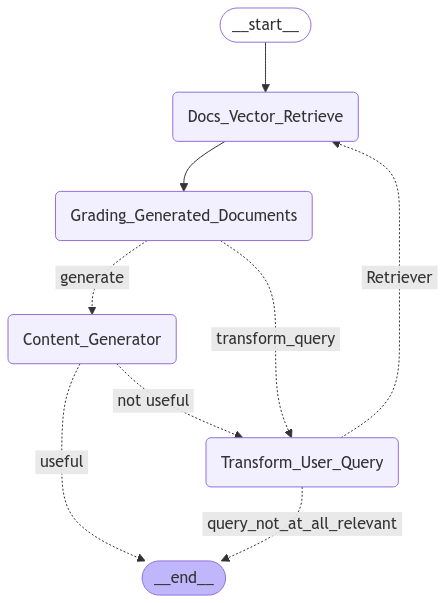

In [83]:
app

In [84]:
inputs = {"question": "Explain how the different types of agent memory work?"}

In [85]:
app.invoke(inputs)["generation"]

----RETRIEVE----
----CHECK DOCUMENTS RELEVANCE TO THE QUESTION----
----GRADE: DOCUMENT RELEVANT----
----GRADE: DOCUMENT RELEVANT----
----GRADE: DOCUMENT RELEVANT----
----GRADE: DOCUMENT RELEVANT----
----ACCESS GRADED DOCUMENTS----
----DECISION: GENERATE----
----GENERATE----
---CHECK HELLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION ---
---DECISION: GENERATION ADDRESS THE QUESTION ---


AIMessage(content='The provided text describes two main types of agent memory: short-term memory and long-term memory. Short-term memory is likened to in-context learning, where the model uses the current prompt and context to learn. Long-term memory stores information over extended periods and often uses an external vector store for efficient retrieval.  \n', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 69, 'prompt_tokens': 2088, 'total_tokens': 2157, 'completion_time': 0.125454545, 'prompt_time': 0.066708296, 'queue_time': 0.024810852999999994, 'total_time': 0.192162841}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'stop', 'logprobs': None}, id='run-d7ffc15d-d752-461f-a077-991a9e0173d6-0', usage_metadata={'input_tokens': 2088, 'output_tokens': 69, 'total_tokens': 2157})